source: [https://docs.unsloth.ai/basics/vision-fine-tuning](https://docs.unsloth.ai/basics/vision-fine-tuning)

### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

### Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3-4b-pt",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.4: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/4.38G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


<a name="Data"></a>
### Data Prep
We'll use a sampled dataset of handwritten math formulas. The objective is to convert these images into a computer-readable format—specifically LaTeX—so they can be rendered. This is particularly useful for complex expressions.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [ ]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

Let's take an overview of the dataset. We'll examine the second image and its corresponding caption.

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

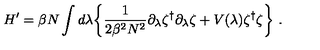

In [ ]:
dataset[2]["image"]

In [ ]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

We can also render LaTeX directly in the browser!

In [ ]:
from IPython.display import display, Math, Latex

latex = dataset[2]["text"]
display(Math(latex))

<IPython.core.display.Math object>

To format the dataset, all vision fine-tuning tasks should follow this format:

```python
[
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]},
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]},
        ],
    },
]
```

In [ ]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["text"]}]},
    ]
    return {"messages": conversation}
pass

Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

Lets take the Gemma 3 instruction chat template and use it in our base model

In [ ]:
from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3"
)

Before fine-tuning, let us evaluate the base model's performance. We do not expect strong results, as it has not encountered this chat template before.

In [ ]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

ഒരു
<start_of_image>

The equation of a straight line is given as . This equation represents the path of a point moving at a constant speed along a circular path centred at the origin in the xy-plane.

The parametric equation that represents the straight line path is given by:
,
,
and .

Where x and y represents the coordinates of the moving point on the circular path, N is a constant representing the speed, u represents the angle of a certain instant of time of the moving particle measured anticlockwise, and (cosu, sinu) represents the coordinates of the moving point at that instant.

The speed


You can see it's absolutely terrible! It doesn't follow instructions at all

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        max_steps = 30,
        #num_train_epochs = 2,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    )
)

Unsloth: Switching to float32 training since model cannot work with float16


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")


GPU = Tesla T4. Max memory = 14.741 GB.
5.416 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)


Step,Training Loss
1,2.232800
2,2.741200
3,2.108200
4,2.385800
5,1.899700
6,1.720900
7,0.959800
8,0.794500
9,0.816100
10,0.398300


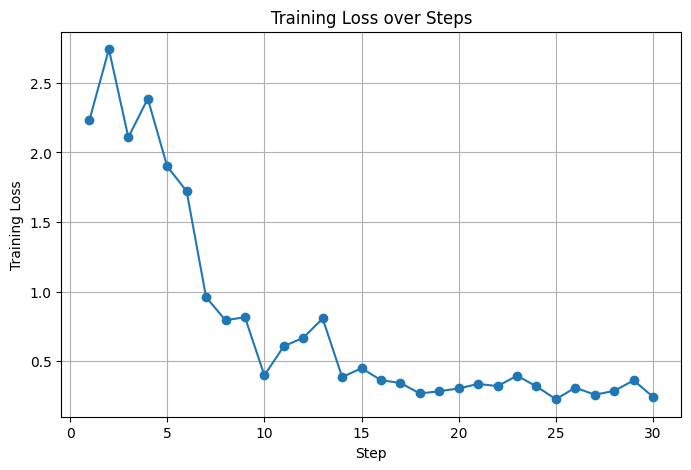

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

steps = [log["step"] for log in logs if "loss" in log]
losses = [log["loss"] for log in logs if "loss" in log]

plt.figure(figsize=(8,5))
plt.plot(steps, losses, marker="o")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

408.7811 seconds used for training.
6.81 minutes used for training.
Peak reserved memory = 5.965 GB.
Peak reserved memory for training = 0.549 GB.
Peak reserved memory % of max memory = 40.465 %.
Peak reserved memory for training % of max memory = 3.724 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can modify the instruction and input—just leave the output blank.

We'll use the best hyperparameters for inference on Gemma: `top_p=0.95`, `top_k=64`, and `temperature=1.0`.

In [ ]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[10]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

[
\left( B _ { n \uparrow } \ , \ b _ { 2 \downarrow } \ , \ \ \left[ \ \ b _ { 2 \downarrow } \ \ , \ b _ { 1 \downarrow } \ \ \right] \ \ \right)
=
n B _ { n \uparrow } \ , \ \ \left( B _ { n \downarrow } \ , \ b _ { 2 \downarrow } \ , \ \left[ \ \ b _ { 2 \uparrow } \ , \ b _ { 1 \downarrow } \ \ \


actual label:

In [ ]:
dataset[10]['text']

'[ [ B _ { n } ^ { + } , b _ { 2 } ^ { - } ] , b _ { 2 } ^ { + } ] = n B _ { n } ^ { + } , \\quad [ [ B _ { n } ^ { - } , b _ { 2 } ^ { + } ] , b _ { 2 } ^ { - } ] = n B _ { n } ^ { - } .'

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, use Hugging Face’s `push_to_hub` for online saving, or `save_pretrained` for local storage.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
processor.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

['lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel

    model, processor = FastVisionModel.from_pretrained(
        model_name="lora_model",  # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit=True,  # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model)  # Enable for inference!

FastVisionModel.for_inference(model)  # Enable for inference!

sample = dataset[1]
image = sample["image"].convert("RGB")
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": sample["text"],
            },
            {
                "type": "image",
            },
        ],
    },
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor.tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

A _ { \mu } ^ { \alpha \beta } \bar { A } _ { \mu } ^ { \alpha \beta } = 0 ,<end_of_turn>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", processor,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", processor, token = "PUT_HERE")